In [25]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
initLogging("Common init")

dvc = torch.device("cpu")
log("device", dvc.type)

Common init:             -------------------------- 2023-07-31 10:31:08
device:                  cpu


In [27]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:            -------------------------- 2023-07-31 10:31:08
filePath:                ../../data/names.txt
First few words:         ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:            32033
Vocabulary:              ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                    {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                    {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:      3.2958


In [28]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("Words shuffling seed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

contextSize = 3
log("Context size", contextSize)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:         -------------------------- 2023-07-31 10:31:08
Words shuffling seed:    42
Context size:            3
Data dtype:              torch.int64
Training ratio:          0.8
Validation ratio:        0.9
Training:                length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:              length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                    length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [29]:
logSection("Build network")

embeddingDims = 10
log("Embedding dimensions", embeddingDims)

hiddenLayerSize = 100
log("Hidden layers size", hiddenLayerSize)

learningSeed = 2147483647
log("Learning seed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

dtype = torch.float
log("dtype", dtype)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
#@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

#@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

#@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:           -------------------------- 2023-07-31 10:31:09
Embedding dimensions:    10
Hidden layers size:      100
Learning seed:           2147483647
dtype:                   torch.float32
Network Layers Structure:
  Linear 52:             [30, 100]
  BatchNorm1d 53:        [100], [100]
  Tanh 54:               
  Linear 55:             [100, 100]
  BatchNorm1d 56:        [100], [100]
  Tanh 57:               
  Linear 58:             [100, 100]
  BatchNorm1d 59:        [100], [100]
  Tanh 60:               
  Linear 61:             [100, 100]
  BatchNorm1d 62:        [100], [100]
  Tanh 63:               
  Linear 64:             [100, 100]
  BatchNorm1d 65:        [100], [100]
  Tanh 66:               
  Linear 67:             [100, 27]
  BatchNorm1d 68:        [27], [27]
Parameters Count:        47024


Activations distribution - Linear
  Linear 52 [30, 100]:   mean: +0.00362, std: +0.18726, saturated: 0.00%
  Linear 55 [100, 100]:  mean: -0.00055, std: +0.09968, saturated: 0.00%
  Linear 58 [100, 100]:  mean: +0.00051, std: +0.10068, saturated: 0.00%
  Linear 61 [100, 100]:  mean: +0.00206, std: +0.10034, saturated: 0.00%
  Linear 64 [100, 100]:  mean: -0.00048, std: +0.10035, saturated: 0.00%
  Linear 67 [100, 27]:   mean: +0.00052, std: +0.09887, saturated: 0.00%
Plot:                    01 Activations distribution - Linear (10_31_09).png


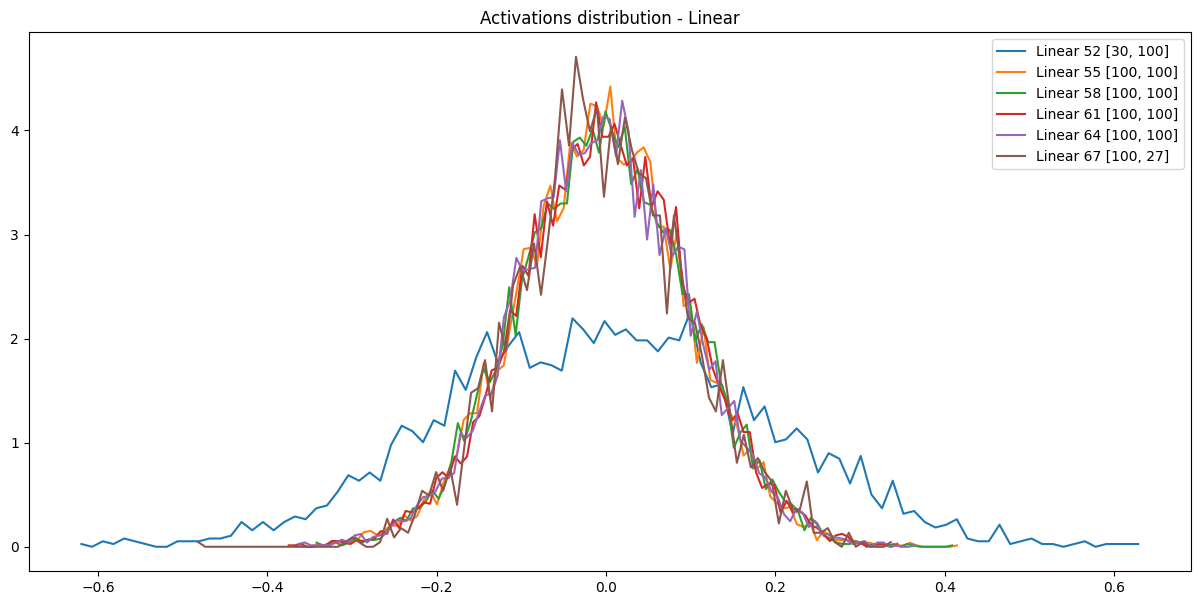

In [30]:
plotActivationsDistribution(Linear, np.layers)

In [31]:
logSection("Training")

trainingBatchSize = 32
log("Training batch size", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("Training steps: ", trainingSteps)

repeats = 36
log("Repeats", repeats)

maxIteration = 100
log("Max iterations", maxIteration)

maxLr = 0.15
log("Max learning rate", maxLr)

minLr = 0.001
log("Min learning rate", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("Actual iterations", actualIterations)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = True;

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
ud: list[list[float]] = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
stopped = False
i = 0

tsl = TrainingStatLists()

for repeat in range(repeats):
    
    if stopped:
        break;

    logSimple(f"{repeat:>3}, {i:>7} losses: {fr.loss.item():>10.4f}   ", end="")
    logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            stopped = True
            log("Stopped at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)
        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        
        if i == 0 or i % 100:
            tsl.ix.append(i)
            tsl.forwardPassLoss.append(fr.loss.item())
            tsl.learningRate.append(up.learningRate)
            tsl.paramGradStd.append([p.grad.std() for p in np.parameters])
            tsl.paramDataStd.append([p.data.std() for p in np.parameters])
            
            lrAtIx.append(up.learningRate)
            stepIx.append(i)
            lossAtIx.append(fr.loss.item())
            logLossAtIx.append(fr.loss.log10().item())
            with torch.no_grad():
                vals = [((up.learningRate * (p.grad)).std() / p.data.std()).log10().item() for p in np.parameters]
                ud.append(vals)

        i += 1

logSimple(f"Final losses: {fr.loss.item():>17.4f}   ", end="")
#logLosses()

log("Embedding shape", fr.emb.shape)
log("Logits shape", fr.logits.shape)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = False;

Training:                -------------------------- 2023-07-31 10:31:09
Training batch size:     32
Training steps: :        5708
Repeats:                 36
Max iterations:          100
Max learning rate:       0.15
Min learning rate:       0.001
Actual iterations:       100
  0,       0 losses:     0.0000       3.3000     3.3010     3.3002
Stopped at max iteration:
Final losses:            2.9222   Embedding shape:         [32, 3, 10]
Logits shape:            [32, 27]


In [32]:
logSection("Introspection")

Introspection:           -------------------------- 2023-07-31 10:31:10


Max learning rate:       0.15
Min learning rate:       0.0024899999999999922
Plot:                    03 Learning rate progress (10_31_35).png


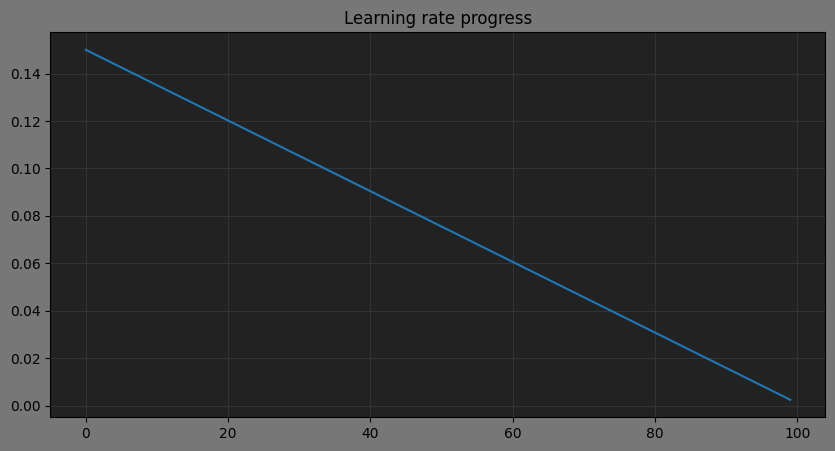

In [35]:

log("Max learning rate", max(tsl.learningRate))
log("Min learning rate", min(tsl.learningRate))
plotXY(tsl.ix, tsl.learningRate, "Learning rate progress")

Activations distribution - Linear
  Linear 52 [30, 100]:   mean: +0.07042, std: +0.54385, saturated: 7.19%
  Linear 55 [100, 100]:  mean: -0.00275, std: +0.67119, saturated: 14.97%
  Linear 58 [100, 100]:  mean: +0.00652, std: +0.64421, saturated: 12.47%
  Linear 61 [100, 100]:  mean: -0.00168, std: +0.64898, saturated: 12.88%
  Linear 64 [100, 100]:  mean: -0.00029, std: +0.65464, saturated: 13.50%
  Linear 67 [100, 27]:   mean: -0.00205, std: +0.72599, saturated: 17.36%
Plot:                    04 Activations distribution - Linear (10_31_36).png


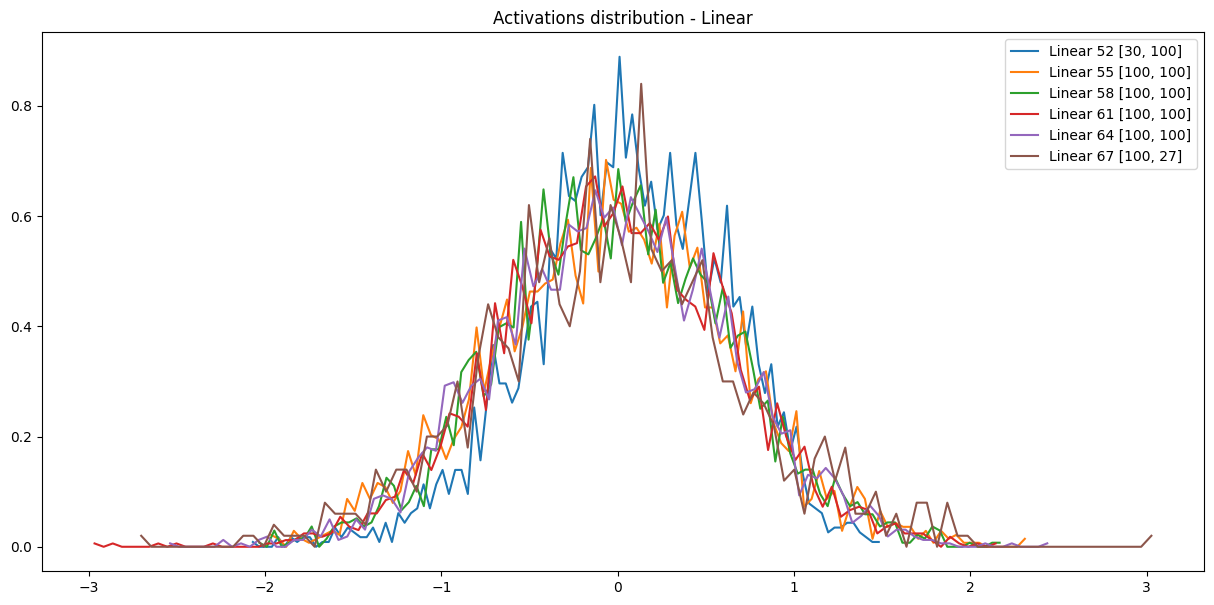

In [36]:
plotActivationsDistribution(Linear, np.layers)

Activations distribution - BatchNorm1d
  BatchNorm1d 53 [100], [100]: mean: -0.00008, std: +0.98425, saturated: 34.50%
  BatchNorm1d 56 [100], [100]: mean: +0.00009, std: +0.98423, saturated: 34.59%
  BatchNorm1d 59 [100], [100]: mean: -0.00018, std: +0.98435, saturated: 34.53%
  BatchNorm1d 62 [100], [100]: mean: -0.00038, std: +0.98447, saturated: 34.50%
  BatchNorm1d 65 [100], [100]: mean: -0.00009, std: +0.98441, saturated: 34.38%
  BatchNorm1d 68 [27], [27]: mean: -0.00000, std: +0.33374, saturated: 2.78%
Plot:                    05 Activations distribution - BatchNorm1d (10_31_36).png


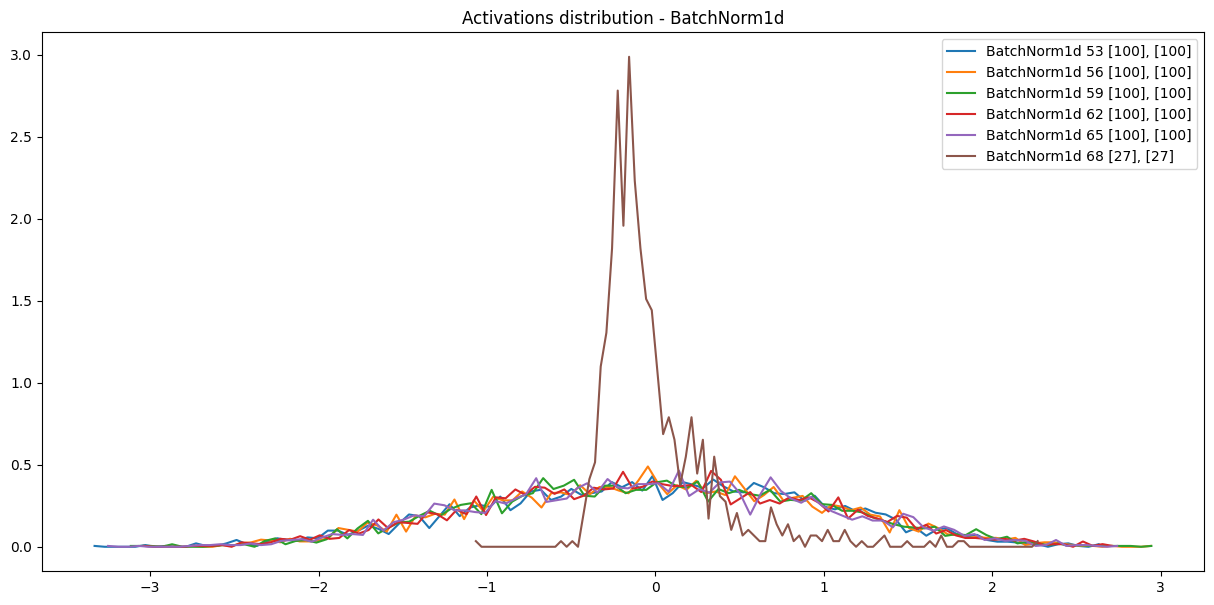

In [37]:
plotActivationsDistribution(BatchNorm1d, np.layers)

Activations distribution - Tanh
  Tanh 54:               mean: +0.01076, std: +0.63616, saturated: 2.56%
  Tanh 57:               mean: +0.00203, std: +0.63674, saturated: 2.72%
  Tanh 60:               mean: -0.00222, std: +0.63728, saturated: 2.38%
  Tanh 63:               mean: -0.00156, std: +0.63523, saturated: 2.91%
  Tanh 66:               mean: -0.00003, std: +0.63646, saturated: 2.44%
Plot:                    06 Activations distribution - Tanh (10_31_36).png


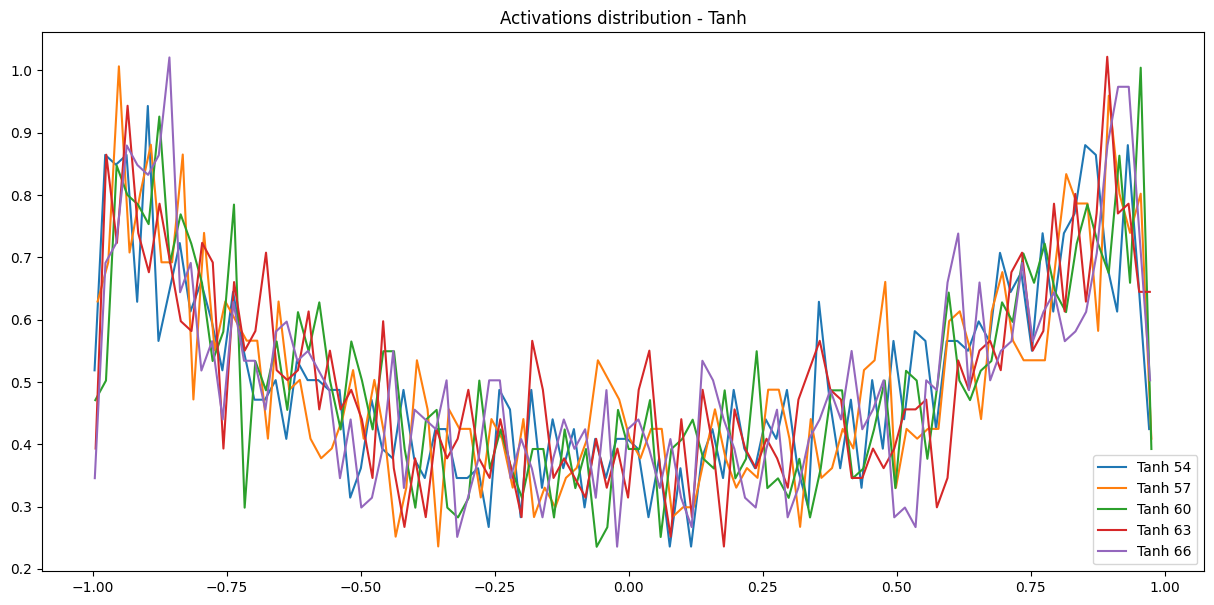

In [38]:
# for use without batch norm (lin with bias) std should be ~0.5 and sat ~5% 
plotActivationsDistribution(Tanh, np.layers)

Activations distribution - Linear (Grad)
  Linear 52 [30, 100]:   mean: +0.00000, std: +0.00434
  Linear 55 [100, 100]:  mean: +0.00000, std: +0.00165
  Linear 58 [100, 100]:  mean: +0.00000, std: +0.00145
  Linear 61 [100, 100]:  mean: +0.00000, std: +0.00117
  Linear 64 [100, 100]:  mean: +0.00000, std: +0.00111
  Linear 67 [100, 27]:   mean: -0.00000, std: +0.00193
Plot:                    07 Activations distribution - Linear (Grad) (10_31_36).png
Activations distribution - LinearWithBias (Grad)
Plot:                    08 Activations distribution - LinearWithBias (Grad) (10_31_36).png
Activations distribution - BatchNorm1d (Grad)
  BatchNorm1d 53 [100], [100]: mean: -0.00001, std: +0.00113
  BatchNorm1d 56 [100], [100]: mean: -0.00001, std: +0.00104
  BatchNorm1d 59 [100], [100]: mean: +0.00001, std: +0.00087
  BatchNorm1d 62 [100], [100]: mean: +0.00000, std: +0.00074
  BatchNorm1d 65 [100], [100]: mean: -0.00000, std: +0.00070
  BatchNorm1d 68 [27], [27]: mean: -0.00000, std: +0.

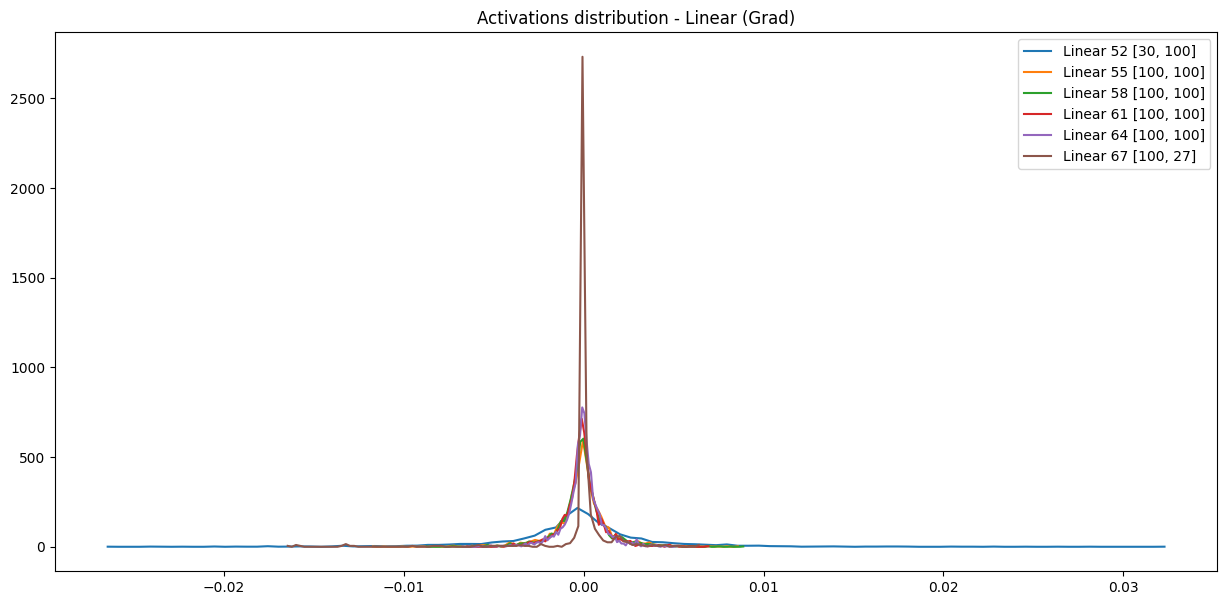

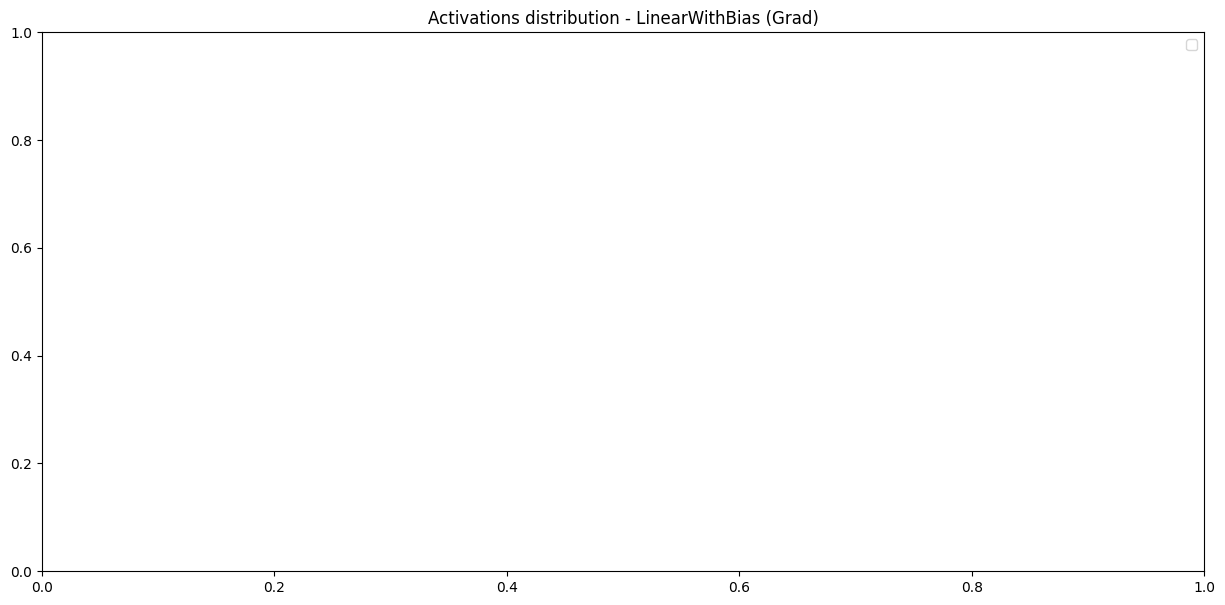

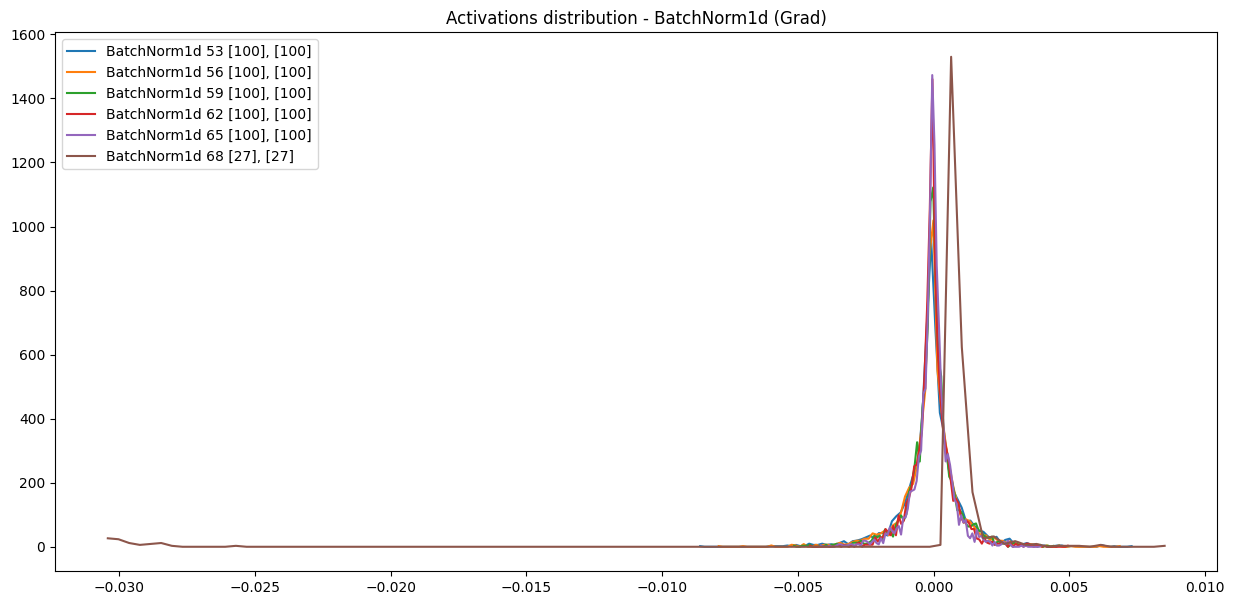

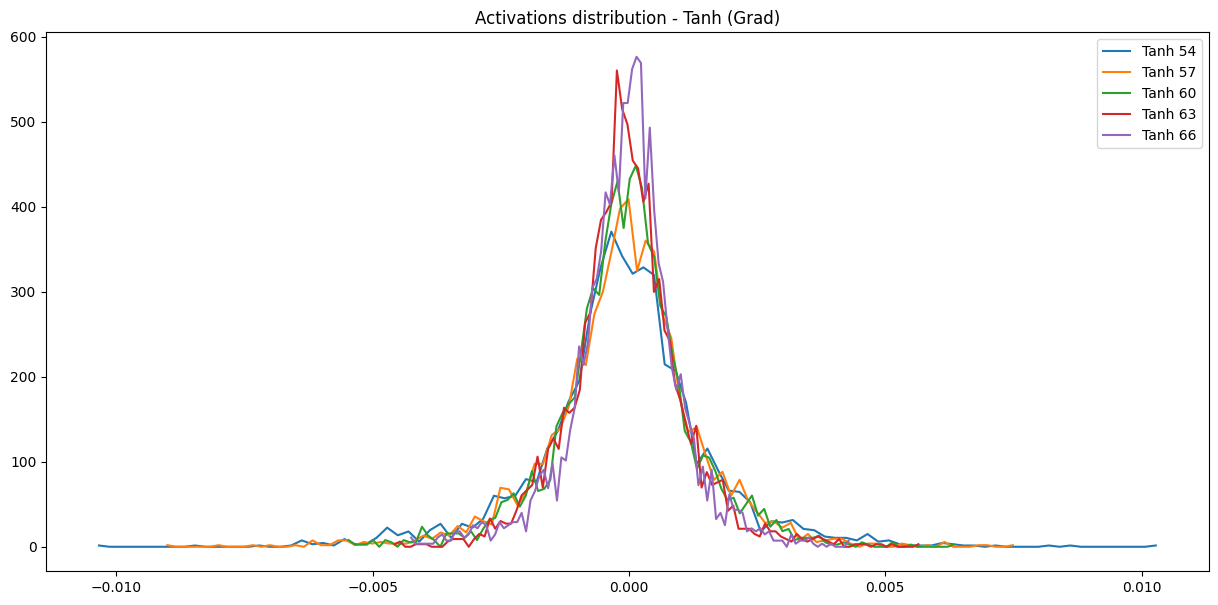

In [39]:
plotActivationsDistribution(Linear, np.layers, useGrad=True)
plotActivationsDistribution(LinearWithBias, np.layers, useGrad=True)
plotActivationsDistribution(BatchNorm1d, np.layers, useGrad=True)
plotActivationsDistribution(Tanh, np.layers, useGrad=True)

Gradients weights distribution
  C
    Weight:                [27, 10], mean: +0.00000, std: 1.658366e-02, data ratio: 5.919933e-02
  Linear 52 [30, 100]    Weight:               [30, 100], mean: -0.00013, std: 6.128005e-03, data ratio: 3.271830e-02
  Linear 55 [100, 100]    Weight:              [100, 100], mean: -0.00005, std: 5.775327e-03, data ratio: 5.791066e-02
  Linear 58 [100, 100]    Weight:              [100, 100], mean: -0.00001, std: 5.142545e-03, data ratio: 5.105930e-02
  Linear 61 [100, 100]    Weight:              [100, 100], mean: +0.00001, std: 4.095952e-03, data ratio: 4.080846e-02
  Linear 64 [100, 100]    Weight:              [100, 100], mean: +0.00004, std: 4.038472e-03, data ratio: 4.023359e-02
  Linear 67 [100, 27]    Weight:               [100, 27], mean: -0.00003, std: 7.093798e-03, data ratio: 7.169503e-02
Plot:                    11 Gradients weights distribution (10_31_37).png


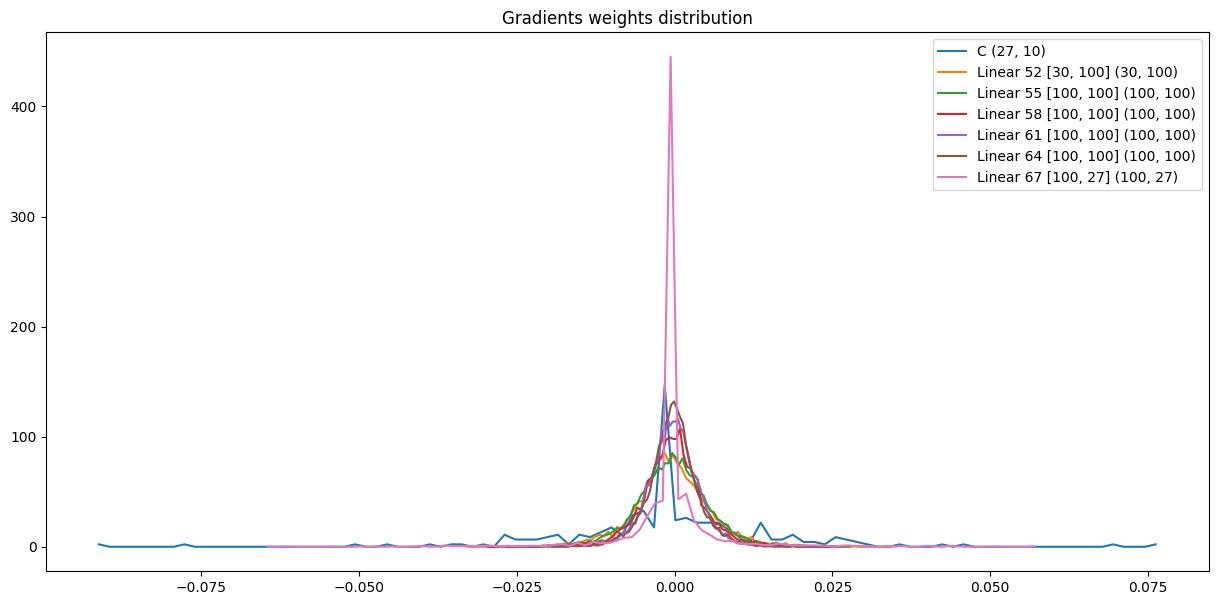

In [40]:
plotGradWeightsDistribution(Linear, np.C, np.layers)

Plot:                    12 Gradient update - Data ratio (10_31_37).png


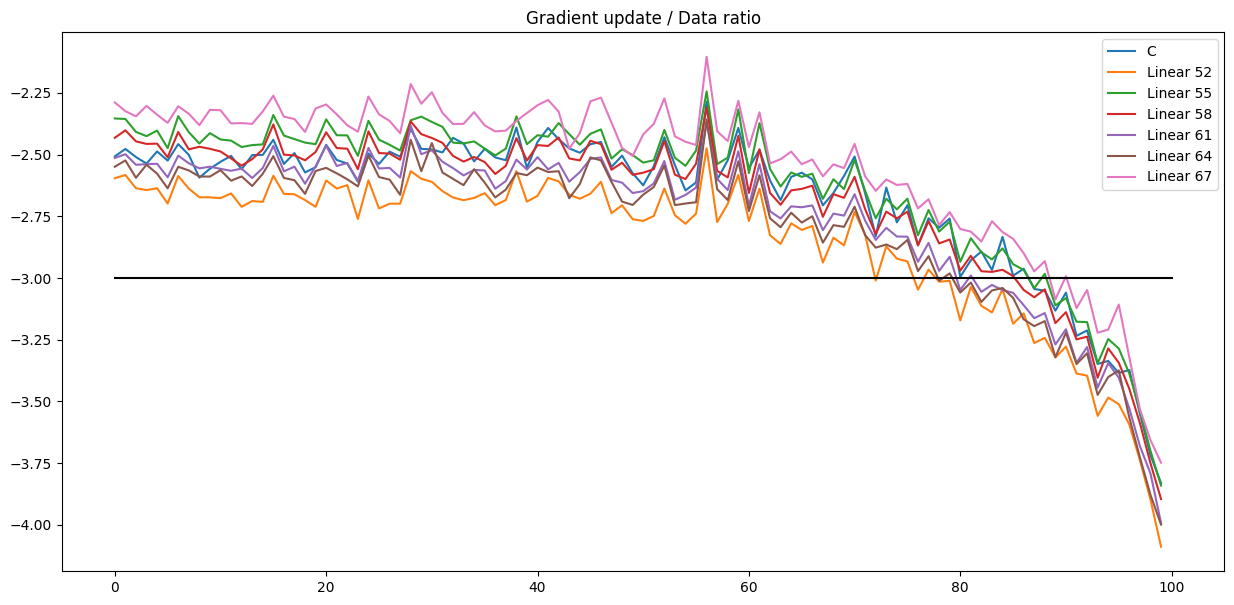

In [41]:
plotGradientUpdateRatio(ud, np.parameters, np.paramNames)

Plot:                    13 Learning rate - batch loss, per forward pass (10_31_37).png


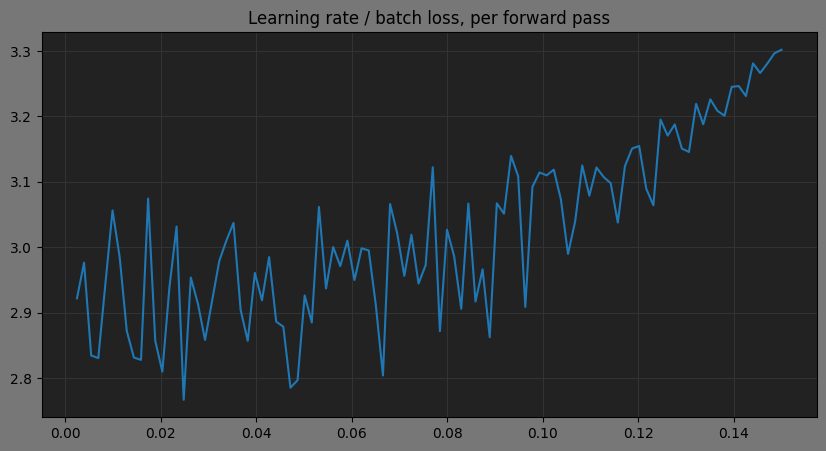

In [42]:
plotXY(tsl.learningRate, tsl.forwardPassLoss, "Learning rate / batch loss, per forward pass")

Plot:                    14 Learning batch loss per forward pass (10_31_37).png


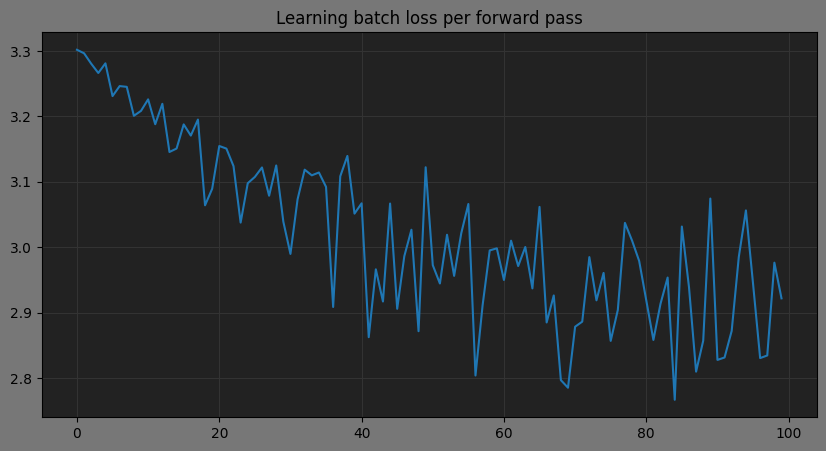

In [43]:
plotXY(tsl.ix, tsl.forwardPassLoss, "Learning batch loss per forward pass")

Plot:                    15 Learning batch log-loss at training step (10_31_38).png


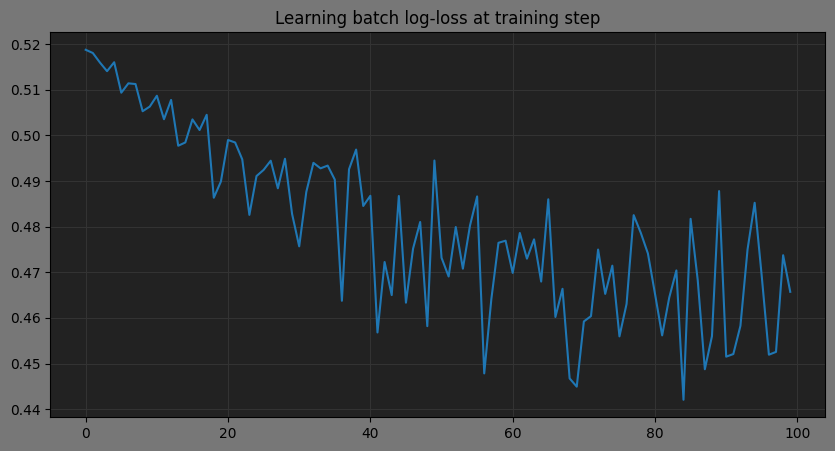

In [44]:
plotXY(tsl.ix, [math.log10(x) for x in tsl.forwardPassLoss], "Learning batch log-loss at training step")

Plot:                    16 Embedding at [0, 1] (10_31_38).png


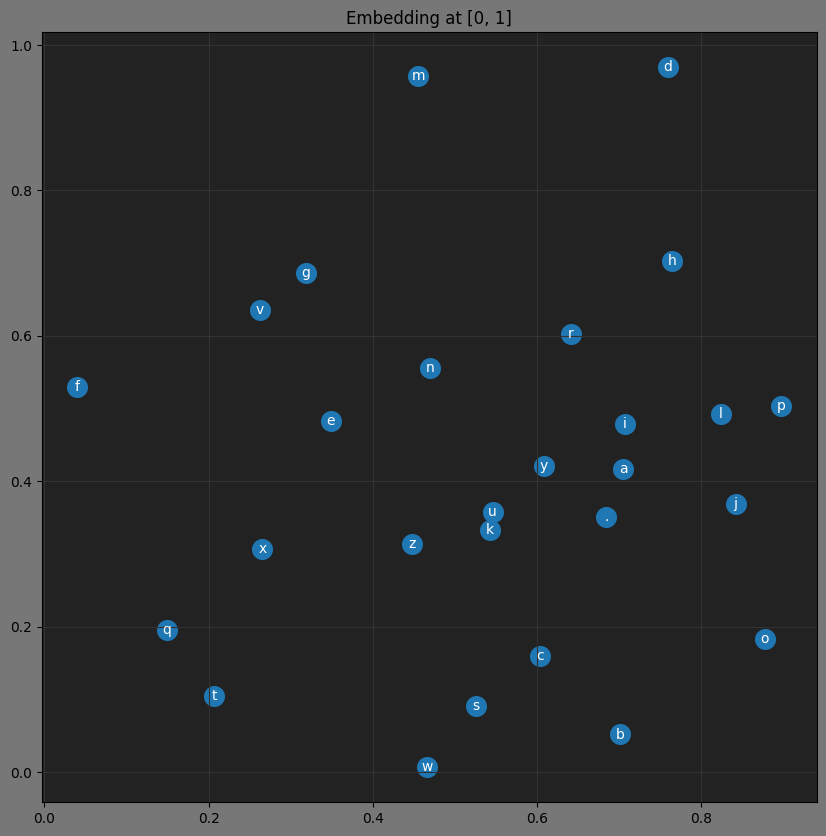

In [45]:
plotEmb(np.C, ldr.itos, 0)

In [46]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:                -------------------------- 2023-07-31 10:31:38
samplingSeed:            2147483657
maxSampleLength:         50


In [47]:
samples = sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

carpahxqab.            20: 8 37 14 8 25 8 7 7 19 8 44 
hqvifk.                25: 10 6 8 13 7 10 51 
mrpxrthtykhncasskejrzhnbnfqpesyhc.  14: 10 9 7 7 10 7 8 7 10 8 8 13 8 14 9 9 9 10 9 13 7 9 15 9 11 8 8 7 15 9 7 8 7 35 
vgqei.                 25: 8 8 6 12 11 49 
nelmuqa.               31: 10 17 16 7 8 8 37 52 
cmaiiv.                28: 8 9 68 12 12 7 46 
kslhggph.              25: 12 8 10 9 7 7 8 9 54 
bm.                    49: 11 7 19 
poin.                  30: 7 9 12 25 35 
qdqjn.                 23: 8 10 7 7 13 60 
srlinwa.               24: 9 11 11 12 24 7 14 33 
vvdbq.                 21: 8 8 11 7 7 27 
wqje.                  26: 8 7 8 12 45 
ogdjaryxixfkqeupiusdbwed.  14: 9 7 10 9 13 12 12 8 13 8 7 8 8 12 8 7 14 7 9 7 7 9 15 7 28 
ecxia.                 39: 12 9 9 13 17 35 
gtlefhysfl.            17: 8 7 19 13 7 9 9 9 8 13 24 
ahpag.                 74: 25 11 7 26 7 26 
bvdjhksya.             22: 11 8 10 8 9 7 9 11 19 34 
imqqosozswjcojn.       19: 12 9 7 8 9 8 8 7 9 8 9 8 8 

In [48]:
logSection("Probabilities")

def printProb(txt: str):
    ps = calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<25}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('carol.')
printProb('karol.')
printProb('karel.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('andrew.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')
printProb('x.')
printProb('xx.')
printProb('xxx.')
printProb('xxxx.')

Probabilities:           -------------------------- 2023-07-31 10:31:38
.                        293    : 8 
m.                       66     : 10 9 
mi.                      37     : 10 12 7 
mic.                     39     : 10 12 8 30 
mich.                    38     : 10 12 8 9 86 
micha.                   27     : 10 12 8 9 16 20 
michal.                  26     : 10 12 8 9 16 15 24 
michael.                 26     : 10 12 8 9 16 12 13 38 
michaela.                26     : 10 12 8 9 16 12 13 21 36 
michaella.               24     : 10 12 8 9 16 12 13 10 21 40 
michel.                  25     : 10 12 8 9 9 14 35 
carol.                   33     : 8 37 14 12 16 28 
karol.                   54     : 12 48 14 12 16 28 
karel.                   56     : 12 48 14 13 13 41 
martin.                  37     : 10 73 15 8 11 14 37 
andrej.                  71     : 25 12 10 10 13 9 41 
andrey.                  67     : 25 12 10 10 13 9 25 
andrew.                  67     : 25 12 10 10 13 8 28